# Feature selection

In [1]:
import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import xgboost as xgb

# Data preparation
## Merging of data from steps 1 and 2

In [2]:
df_etap_1 = pd.read_csv('reddit_etap_1_v4.csv', index_col='id')
df_etap_1 = df_etap_1.drop(columns = ['Unnamed: 0'])
df_etap_2 = pd.read_csv('df_full_etap2.csv', index_col='id')

In [3]:
df_etap_3_before = df_etap_1.merge(df_etap_2, on='id', how='left')

## Deletion of unnecessary columns

In [5]:
df_etap_3_before = df_etap_3_before.drop(columns=[
    'title', 'url', 'body', 'created', 'timestamp', 'preprocessed_title', 'full_text',
    'preprocessed_body', 'url_netloc', 'img_txt', 'preprocessed_img_txt',
])

## Update of score values

In [6]:
df_new_score = pd.read_csv('reddit_wsb_new_scores.csv', index_col='id')
df_new_score = df_new_score.drop(columns = ['Unnamed: 0'])

In [7]:
df_etap_3_before.score = df_new_score.new_score

In [9]:
df_etap_3_before.loc[df_etap_3_before.score >= 0]
df_etap_3_before = df_etap_3_before[~df_etap_3_before.index.duplicated(keep='first')]

In [12]:
df_etap_3_before.to_csv('df_etap3_before_new_score.csv')
df_etap_3_before.sample(5)

,score,comms_num,full_text_length,num_letters_title,num_letters_body,num_words_title,num_words_body,num_unique_words_title,num_unique_words_body,capital_title_perc,...,m_v1_251,m_v1_252,m_v1_253,m_v1_254,m_v1_255,full_img_txt_length,num_letters_img_txt,num_words_img_txt,num_unique_words_img_txt,capital_img_txt_perc
id,,,,,,,,,,,,,,,,,,,,,
ldk1g2,22,0,10,9,NaN,2,0,2,0,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lcl2oj,88,15,1616,58,2912.0,3,241,3,170,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lbfbeb,45,13,2912,45,3287.0,4,303,4,199,0.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l9fnu2,32909,167,67,56,NaN,7,0,5,0,0.125000,...,0.0,3.434734,0.906182,0.0,0.198155,3.0,3.0,0.0,0.0,0.000000
l9f17u,3226,128,29,45,NaN,5,0,5,0,1.000000,...,0.0,0.568259,0.000000,0.0,0.000000,174.0,174.0,23.0,23.0,0.719512


## Separate columns with features and target variables

In [13]:
df_target = df_etap_3_before[['score', 'comms_num']]
df_target.to_csv('df_etap_3_before_target.csv')

df_features = df_etap_3_before.drop(columns=['score', 'comms_num'])
df_features.sentiment = df_features.sentiment.map({'neg': 0, 'neu': 1, 'pos': 2, 0: 0, 1: 1, 2: 2})
df_features.to_csv('df_etap_3_before_features.csv')

# Preparing data for analysis
Data loading

In [10]:
df_features = pd.read_csv('df_etap_3_before_features.csv', index_col = 'id')
df_target = pd.read_csv('df_etap_3_before_target.csv', index_col = 'id').loc[:, 'score']

Selection of columns with categorical features and with features from mobilenet

In [11]:
img_m_v1_cols = [col_name for col_name in df_features.columns if col_name.startswith('m_v1_')]
img_stats_cols = [col_name for col_name in df_features.columns if col_name.startswith('img_')]
img_txt_cols = ['full_img_txt_length', 'num_letters_img_txt', 'num_words_img_txt',
                'num_unique_words_img_txt', 'capital_img_txt_perc']
categorical_cols = ['sentiment', 'lda_topic', 'sub_group', 'group', 'weekday']

Remaining columns

In [12]:
list(df_features.columns[~df_features.columns.isin(img_m_v1_cols + img_stats_cols + img_txt_cols + categorical_cols)])

['full_text_length',
 'num_letters_title',
 'num_letters_body',
 'num_words_title',
 'num_words_body',
 'num_unique_words_title',
 'num_unique_words_body',
 'capital_title_perc',
 'capital_body_perc',
 'VS_pos',
 'VS_neu',
 'VS_neg',
 'compound',
 'emoji_title_perc',
 'emoji_body_perc',
 'title_emoji_count',
 'body_emoji_count',
 'total_emoji_count',
 'is_emoji',
 'unique_emojis',
 'repeated_emojis_ratio',
 'emoji_rocket',
 'emoji_gem_stone',
 'emoji_raising_hand',
 'emoji_gorilla',
 'emoji_raised_hand',
 'emoji_open_hand',
 'emoji_light_skin_tone',
 'emoji_palms_up_together',
 'emoji_full_moon',
 'emoji_raised_back_of_hand',
 'emoji_medium_light_skin_tone',
 'emoji_hand_with_fingers_splaye',
 'emoji_banana',
 'emoji_full_moon_face',
 'emoji_rainbow',
 'emoji_crescent_moon',
 'emoji_medium_skin_tone',
 'emoji_bear_face',
 'emoji_new_moon_face',
 'emoji_fire',
 'lda_topic_prob',
 'minutes_from_midnight',
 'hours_from_midnight',
 'weeks_from_start',
 'days_from_start']

## Replacing categorical attributes with one-hot vectors

In [13]:
for caco in categorical_cols:
    df_new_cols = pd.get_dummies(df_features.loc[:, caco])
    df_new_cols.columns = [f'{caco}_{i}' for i in df_new_cols.columns]
    df_features = df_features.merge(df_new_cols, on='id', how='left')
    df_features = df_features.drop(columns=[caco])

In [14]:
df_features.loc[:, 'sentiment_0':].sample(5)

,sentiment_0,sentiment_1,sentiment_2,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5,sub_group_0,...,group_2,group_3,group_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
id,,,,,,,,,,,,,,,,,,,,,
l6sfss,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
l6yzjk,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
l712tc,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
ldqlao,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
l6yzu9,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [15]:
new_order = df_features.loc[:, :'days_from_start'].columns.tolist() +\
    df_features.loc[:, 'sentiment_0':].columns.tolist() +\
    df_features.loc[:, 'img_has_ph':'capital_img_txt_perc'].columns.tolist()

In [16]:
df_features = df_features[new_order]
df_features.sample(5)

,full_text_length,num_letters_title,num_letters_body,num_words_title,num_words_body,num_unique_words_title,num_unique_words_body,capital_title_perc,capital_body_perc,VS_pos,...,m_v1_251,m_v1_252,m_v1_253,m_v1_254,m_v1_255,full_img_txt_length,num_letters_img_txt,num_words_img_txt,num_unique_words_img_txt,capital_img_txt_perc
id,,,,,,,,,,,,,,,,,,,,,
ldswvm,713,61,1122.0,4,109,4,96,0.057692,0.036005,0.154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lcd8sv,87,36,120.0,2,13,2,13,0.035714,0.044444,0.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lapi5q,752,26,1250.0,2,94,2,71,1.000000,0.130297,0.184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l727vj,212,95,308.0,8,22,8,17,0.062500,0.056680,0.114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l74ta1,685,105,926.0,11,96,11,63,0.144578,0.050562,0.064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
list(df_features.columns)

['full_text_length',
 'num_letters_title',
 'num_letters_body',
 'num_words_title',
 'num_words_body',
 'num_unique_words_title',
 'num_unique_words_body',
 'capital_title_perc',
 'capital_body_perc',
 'VS_pos',
 'VS_neu',
 'VS_neg',
 'compound',
 'emoji_title_perc',
 'emoji_body_perc',
 'title_emoji_count',
 'body_emoji_count',
 'total_emoji_count',
 'is_emoji',
 'unique_emojis',
 'repeated_emojis_ratio',
 'emoji_rocket',
 'emoji_gem_stone',
 'emoji_raising_hand',
 'emoji_gorilla',
 'emoji_raised_hand',
 'emoji_open_hand',
 'emoji_light_skin_tone',
 'emoji_palms_up_together',
 'emoji_full_moon',
 'emoji_raised_back_of_hand',
 'emoji_medium_light_skin_tone',
 'emoji_hand_with_fingers_splaye',
 'emoji_banana',
 'emoji_full_moon_face',
 'emoji_rainbow',
 'emoji_crescent_moon',
 'emoji_medium_skin_tone',
 'emoji_bear_face',
 'emoji_new_moon_face',
 'emoji_fire',
 'lda_topic_prob',
 'minutes_from_midnight',
 'hours_from_midnight',
 'weeks_from_start',
 'days_from_start',
 'sentiment_0',
 '

## Filling in missing values

In [18]:
df_features.num_letters_body = df_features.num_letters_body.fillna(0)
df_features[~df_features.m_v1_255.isna()] = df_features[~df_features.m_v1_255.isna()].fillna(0)

In [19]:
df_features.loc[df_features.img_has_ph==1, 'img_height':] = np.nan

In [20]:
df_features.sample(5)

,full_text_length,num_letters_title,num_letters_body,num_words_title,num_words_body,num_unique_words_title,num_unique_words_body,capital_title_perc,capital_body_perc,VS_pos,...,m_v1_251,m_v1_252,m_v1_253,m_v1_254,m_v1_255,full_img_txt_length,num_letters_img_txt,num_words_img_txt,num_unique_words_img_txt,capital_img_txt_perc
id,,,,,,,,,,,,,,,,,,,,,
l6x1js,31,13,0.0,3,0,2,0,0.111111,0.000000,0.000,...,0.0,1.242174,2.043128,0.001889,0.767118,65.0,65.0,9.0,9.0,0.093023
lc6png,330,14,538.0,2,45,2,39,0.500000,0.140306,0.212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l9v2io,876,96,928.0,20,74,14,64,0.424242,0.112573,0.275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l71gkx,10,9,0.0,1,0,1,0,0.444444,0.000000,0.000,...,0.0,2.708736,0.415638,0.000000,0.073809,506.0,506.0,54.0,47.0,0.082873
ld33bm,158,65,253.0,6,20,6,20,0.100000,0.026738,0.298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split into a train set and test set

In [21]:
df_f_train, df_f_test, df_t_train, df_t_test = train_test_split(df_features, df_target, random_state=0)

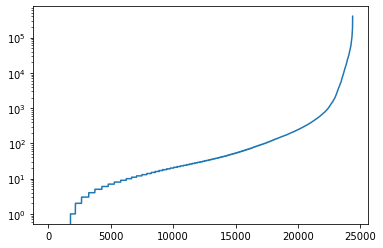

In [22]:
plt.plot(np.sort(df_t_train.values))
plt.yscale('log')

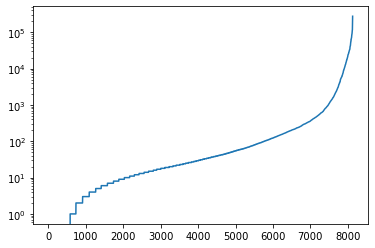

In [23]:
plt.plot(np.sort(df_t_test.values))
plt.yscale('log')

## Visual analysis of the relationship between exemplary features

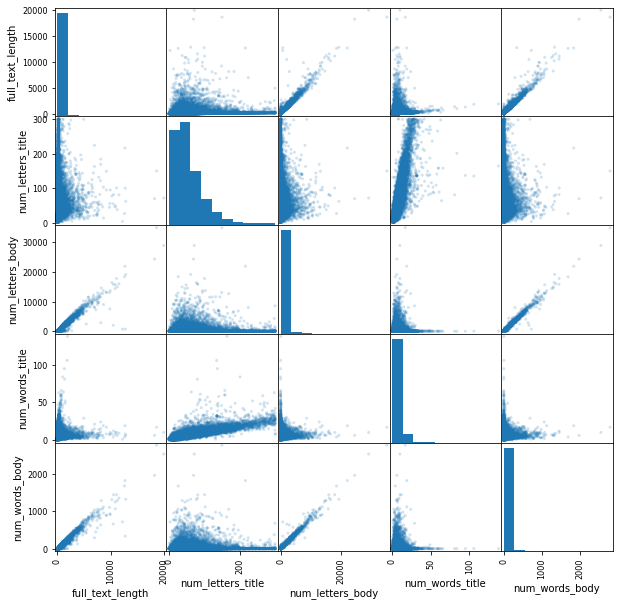

In [29]:
df_f_plot1 = df_f_train.iloc[:, :5]
sc = StandardScaler()
data = pd.DataFrame(sc.fit_transform(df_f_plot1), columns = df_f_plot1.columns)
pd.plotting.scatter_matrix(df_f_plot1, alpha=0.2, figsize=(10, 10))
plt.show()

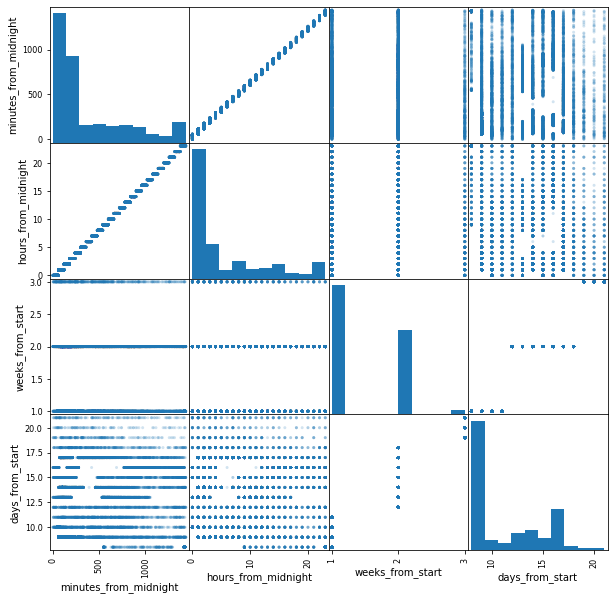

In [32]:
cols = [ 'minutes_from_midnight', 'hours_from_midnight', 'weeks_from_start', 'days_from_start']
df_f_plot2 = df_f_train.loc[:, cols]
sc = StandardScaler()
data = pd.DataFrame(sc.fit_transform(df_f_plot2), columns = df_f_plot2.columns)
pd.plotting.scatter_matrix(df_f_plot2, alpha=0.2, figsize=(10, 10))
plt.show()

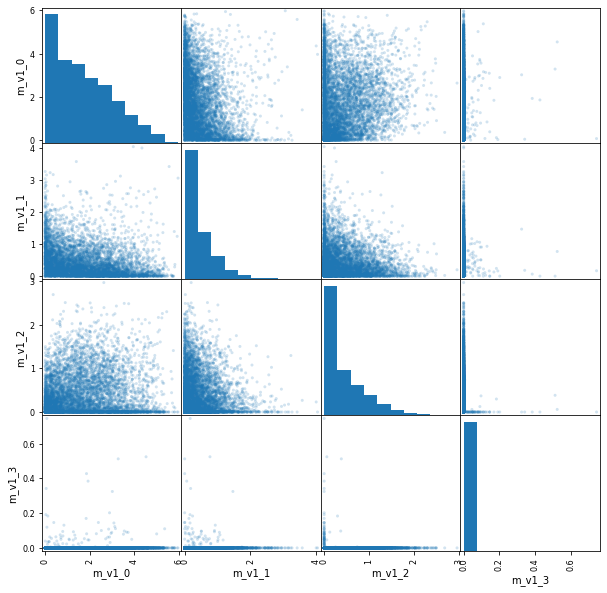

In [34]:
cols = img_m_v1_cols[:4]
df_f_plot3 = df_f_train.loc[:, cols]
sc = StandardScaler()
data = pd.DataFrame(sc.fit_transform(df_f_plot3), columns = df_f_plot3.columns)
pd.plotting.scatter_matrix(df_f_plot3, alpha=0.2, figsize=(10, 10))
plt.show()

## Correlation analysis

In [110]:
def plot_corr(corr):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(corr, fignum=f.number)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()
    
def feature_selection_by_correlation(corr, threshold=0.99):
    to_drop = []
    to_drop_dict = {}
    for i in range(len(corr)):
        col = corr.index[i]
        l = list(corr.columns[i+1:][abs(corr.iloc[i, i+1:])>threshold])
        to_drop += l
        if not col in to_drop_dict and len(l) > 0:
            to_drop_dict[col] = l
    # return set(to_drop)
    return list(set(to_drop)), to_drop_dict

In [106]:
sc = StandardScaler()
df_X_sc = pd.DataFrame(sc.fit_transform(df_f_train), columns = df_f_train.columns)
corr = df_X_sc.corr().fillna(0)

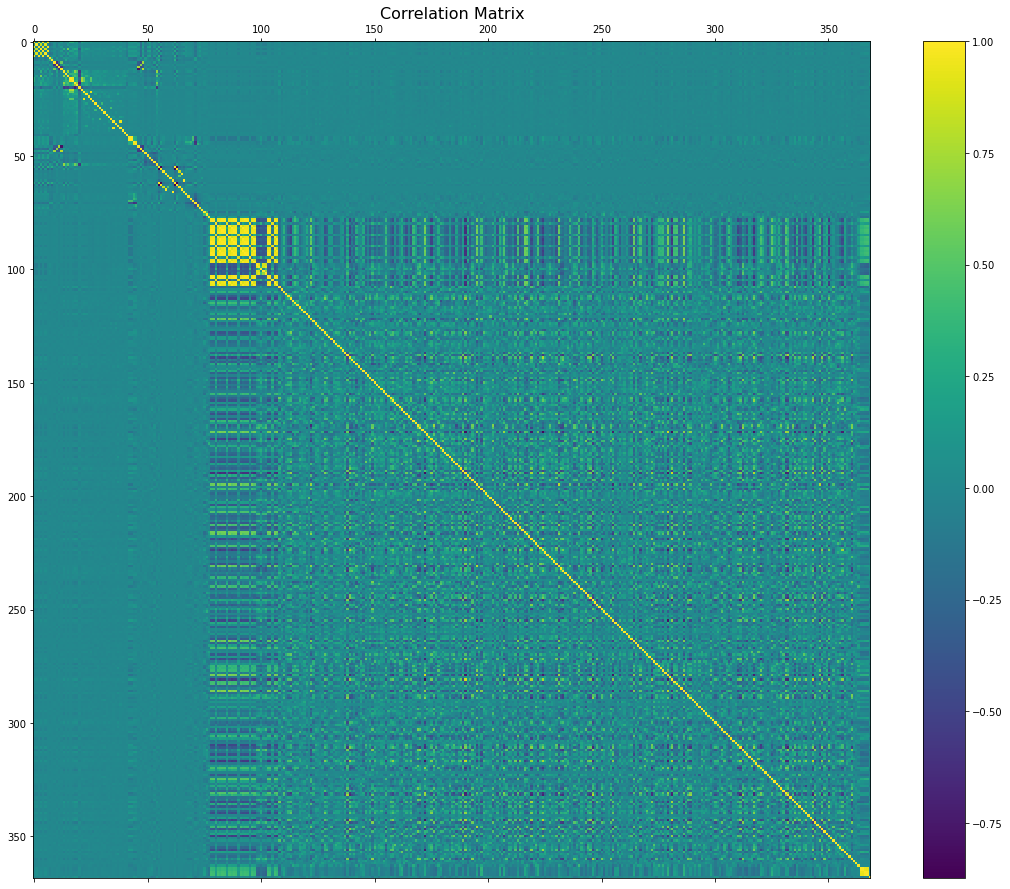

In [107]:
plot_corr(corr)

In [111]:
features_to_drop, dict_to_drop = feature_selection_by_correlation(corr, threshold=0.9)
pprint.pprint(dict_to_drop)

{'body_emoji_count': ['total_emoji_count'],
 'emoji_gem_stone': ['emoji_raised_hand'],
 'emoji_rainbow': ['emoji_bear_face'],
 'full_img_txt_length': ['num_letters_img_txt',
                         'num_words_img_txt',
                         'num_unique_words_img_txt'],
 'full_text_length': ['num_letters_body',
                      'num_words_body',
                      'num_unique_words_body'],
 'img_mean': ['img_quantile_25',
              'img_quantile_75',
              'img_median_b',
              'img_mean_b',
              'img_quantile_25_b',
              'img_quantile_75_b',
              'img_median_g',
              'img_mean_g',
              'img_quantile_25_g',
              'img_quantile_75_g',
              'img_median_r',
              'img_mean_r',
              'img_quantile_25_r',
              'img_quantile_75_r',
              'img_median_v',
              'img_mean_v',
              'img_quantile_25_v',
              'img_quantile_75_v'],
 'img_mean_b': ['

In [116]:
print(f"Number of features to drop: {len(features_to_drop)}")
set(features_to_drop)

Number of features to drop: 41


{'days_from_start',
 'emoji_bear_face',
 'emoji_raised_hand',
 'group_0',
 'group_1',
 'group_3',
 'group_4',
 'hours_from_midnight',
 'img_mean',
 'img_mean_b',
 'img_mean_g',
 'img_mean_r',
 'img_mean_s',
 'img_mean_v',
 'img_median_b',
 'img_median_g',
 'img_median_r',
 'img_median_v',
 'img_quantile_25',
 'img_quantile_25_b',
 'img_quantile_25_g',
 'img_quantile_25_r',
 'img_quantile_25_v',
 'img_quantile_75',
 'img_quantile_75_b',
 'img_quantile_75_g',
 'img_quantile_75_r',
 'img_quantile_75_s',
 'img_quantile_75_v',
 'img_std_b',
 'img_std_g',
 'img_std_r',
 'img_std_v',
 'num_letters_body',
 'num_letters_img_txt',
 'num_unique_words_body',
 'num_unique_words_img_txt',
 'num_unique_words_title',
 'num_words_body',
 'num_words_img_txt',
 'total_emoji_count'}

In [118]:
df_f_train = df_f_train.drop(columns=features_to_drop)
df_f_test = df_f_test.drop(columns=features_to_drop)

# Selection by variance - UNUSED

In [119]:
df_f_train.sample(5)

,full_text_length,num_letters_title,num_words_title,capital_title_perc,capital_body_perc,VS_pos,VS_neu,VS_neg,compound,emoji_title_perc,...,m_v1_248,m_v1_249,m_v1_250,m_v1_251,m_v1_252,m_v1_253,m_v1_254,m_v1_255,full_img_txt_length,capital_img_txt_perc
id,,,,,,,,,,,,,,,,,,,,,
l6zeqx,42,63,10,0.130435,0.000000,0.000,0.484,0.516,-0.7506,0.0,...,0.000000,0.201354,0.217812,0.000000,0.442064,0.275685,0.000000,0.751011,182.0,0.219048
l6zgot,56,54,6,0.025641,0.000000,0.000,1.000,0.000,0.0000,0.5,...,0.000000,0.072552,0.185169,0.000000,0.291834,0.000000,0.000000,0.607137,7.0,0.000000
lecfa0,694,90,12,0.400000,0.163297,0.095,0.887,0.017,0.8176,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l727xn,17,17,2,0.250000,0.000000,0.000,1.000,0.000,0.0000,0.5,...,1.891000,0.575899,0.204340,0.067292,0.027279,2.265339,0.172963,0.080931,3.0,0.000000
l728oq,28,40,5,1.000000,0.000000,0.298,0.319,0.383,-0.2023,0.0,...,0.052665,0.203605,0.003256,0.000000,2.471229,0.079287,0.000000,0.125898,386.0,0.059649


In [121]:
mms = MinMaxScaler()
res_mms = mms.fit_transform(df_f_train)

sel = VarianceThreshold(threshold=0.001)
sel.fit(res_mms)
df_f_train.columns[~sel.get_support()]

Index(['title_emoji_count', 'body_emoji_count', 'unique_emojis',
       'emoji_rocket', 'emoji_gem_stone', 'emoji_raising_hand',
       'emoji_gorilla', 'emoji_open_hand', 'emoji_light_skin_tone',
       'emoji_palms_up_together', 'emoji_full_moon',
       'emoji_raised_back_of_hand', 'emoji_medium_light_skin_tone',
       'emoji_hand_with_fingers_splaye', 'emoji_banana',
       'emoji_full_moon_face', 'emoji_rainbow', 'emoji_crescent_moon',
       'emoji_medium_skin_tone', 'emoji_new_moon_face', 'emoji_fire', 'm_v1_3',
       'm_v1_13', 'm_v1_18', 'm_v1_39', 'm_v1_48', 'm_v1_63', 'm_v1_93',
       'm_v1_129', 'm_v1_134', 'm_v1_160', 'm_v1_184', 'm_v1_214', 'm_v1_216',
       'm_v1_233', 'm_v1_245'],
      dtype='object')

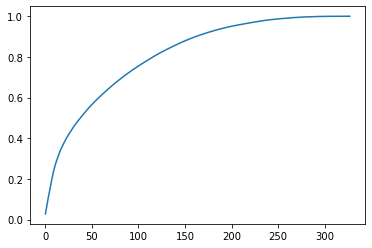

In [122]:
to_plot_var = np.sort(sel.variances_)[::-1]
to_plot_var[np.isnan(to_plot_var)] = 0
to_plot_var /= to_plot_var.sum()
plt.plot(np.cumsum(to_plot_var))

In [123]:
variance_scores = sel.variances_

# Analysis of features from phase 1

In [267]:
df_X1 = df_f_train.copy()
df_X1 = df_X1.loc[:, :'weekday_6']
df_y1 = df_t_train.loc[df_X1.index]
df_X1.sample(5)

,full_text_length,num_letters_title,num_words_title,capital_title_perc,capital_body_perc,VS_pos,VS_neu,VS_neg,compound,emoji_title_perc,...,sub_group_5,sub_group_6,group_2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
id,,,,,,,,,,,,,,,,,,,,,
l70eh0,500,30,3,0.346154,0.081001,0.079,0.829,0.092,0.0000,0.000000,...,0,0,0,0,0,0,0,1,0,0
l71dfz,1260,53,5,0.047619,0.036364,0.319,0.581,0.099,0.9935,0.000000,...,0,0,0,0,0,0,0,1,0,0
l6z01y,145,21,9,0.000000,0.000000,0.000,1.000,0.000,0.0000,0.777778,...,0,0,0,0,0,0,0,1,0,0
ldkijl,151,72,7,0.087719,0.012422,0.095,0.775,0.130,-0.2500,0.000000,...,0,0,0,0,0,0,0,0,1,0
l70xlg,231,51,5,0.095238,0.010274,0.054,0.701,0.245,-0.8481,0.000000,...,0,0,0,0,0,0,0,1,0,0


## Analysis of the correlation between features and the target variable

In [268]:
mms_f = MinMaxScaler()
X1_scaled = mms_f.fit_transform(df_X1)

mms_y = MinMaxScaler()
y1_scaled = mms_y.fit_transform(df_y1.values.reshape(-1, 1)).ravel()

Number of features: 26


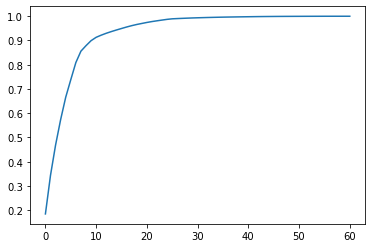

In [269]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X1_scaled, y1_scaled)

sorted_idx = np.argsort(fs.scores_)[::-1]
to_plot = fs.scores_[sorted_idx]
to_plot[np.isnan(to_plot)] = 0
to_plot /= to_plot.sum()
plt.plot(np.cumsum(to_plot))
stage_1_best_features_1 = df_X1.columns[sorted_idx[np.cumsum(to_plot)<0.99]].tolist()
print(f"Number of features: {len(stage_1_best_features_1)}")

Number of features: 46


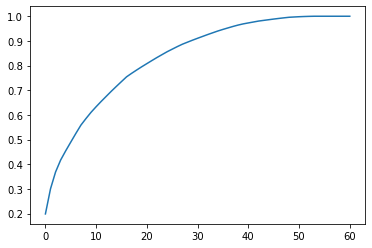

In [270]:
fs2 = SelectKBest(score_func=mutual_info_regression, k='all')
fs2.fit(X1_scaled, y1_scaled)

sorted_idx = np.argsort(fs2.scores_)[::-1]
to_plot2 = fs2.scores_[sorted_idx]
to_plot2[np.isnan(to_plot2)] = 0
to_plot2 /= to_plot2.sum()
plt.plot(np.cumsum(to_plot2))
stage_1_best_features_2 = df_X1.columns[sorted_idx[np.cumsum(to_plot2)<0.99]].tolist()
print(f"Number of features: {len(stage_1_best_features_2)}")

In [272]:
stage_1_best_features = set(stage_1_best_features_1 + stage_1_best_features_2)
print(f"Number of features: {len(stage_1_best_features)}")
stage_1_best_features

Number of features: 50


{'VS_neg',
 'VS_neu',
 'VS_pos',
 'body_emoji_count',
 'capital_body_perc',
 'capital_title_perc',
 'compound',
 'emoji_body_perc',
 'emoji_full_moon',
 'emoji_gem_stone',
 'emoji_gorilla',
 'emoji_hand_with_fingers_splaye',
 'emoji_light_skin_tone',
 'emoji_medium_light_skin_tone',
 'emoji_open_hand',
 'emoji_raising_hand',
 'emoji_rocket',
 'emoji_title_perc',
 'full_text_length',
 'group_2',
 'is_emoji',
 'lda_topic_0',
 'lda_topic_1',
 'lda_topic_2',
 'lda_topic_3',
 'lda_topic_4',
 'lda_topic_5',
 'lda_topic_prob',
 'minutes_from_midnight',
 'num_letters_title',
 'num_words_title',
 'repeated_emojis_ratio',
 'sentiment_0',
 'sentiment_1',
 'sentiment_2',
 'sub_group_0',
 'sub_group_1',
 'sub_group_2',
 'sub_group_4',
 'sub_group_6',
 'title_emoji_count',
 'unique_emojis',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weeks_from_start'}

## Features rejected from stage 1

In [296]:
stage_1_worst_features = df_X1.columns[~df_X1.columns.isin(stage_1_best_features)].tolist()
stage_1_worst_features

['emoji_palms_up_together',
 'emoji_raised_back_of_hand',
 'emoji_banana',
 'emoji_full_moon_face',
 'emoji_rainbow',
 'emoji_crescent_moon',
 'emoji_medium_skin_tone',
 'emoji_new_moon_face',
 'emoji_fire',
 'sub_group_3',
 'sub_group_5']

In [141]:
stage_1_scores_1 = fs.scores_
stage_1_scores_2 = fs2.scores_

# Analysis of features from phase 2

## Analysis of the correlation between features and the target variable

In [208]:
df_X2 = df_f_train.copy()
df_X2 = df_X2.loc[:, 'img_height':]
df_X2.dropna(inplace=True)
df_y2 = df_t_train.loc[df_X2.index]

mms_f = MinMaxScaler()
X2_scaled = mms_f.fit_transform(df_X2)

mms_y = MinMaxScaler()
y2_scaled = mms_y.fit_transform(df_y2.values.reshape(-1, 1)).ravel()
df_X2.sample(5)

,img_height,img_width,img_w2h_ratio,img_median,img_std,img_median_s,img_std_s,img_quantile_25_s,m_v1_0,m_v1_1,...,m_v1_248,m_v1_249,m_v1_250,m_v1_251,m_v1_252,m_v1_253,m_v1_254,m_v1_255,full_img_txt_length,capital_img_txt_perc
id,,,,,,,,,,,,,,,,,,,,,
leab48,2160.0,1080.0,0.500000,0.0,29.509823,0.0,23.865266,0.0,3.862612,0.780681,...,0.686726,0.000000,0.509227,0.002265,0.038614,0.975012,0.0,0.000000,153.0,0.610390
l6yziu,1792.0,828.0,0.462054,240.0,115.224335,0.0,51.957833,0.0,2.086215,0.029831,...,0.185065,0.197168,0.000000,0.000000,0.385175,0.112255,0.0,0.000000,412.0,0.212000
ld3gez,2778.0,1284.0,0.462203,0.0,35.221635,0.0,52.678040,0.0,5.331014,0.210209,...,0.506431,0.000000,0.000000,0.039401,0.101654,0.390650,0.0,0.047571,156.0,0.343750
lcjyqw,1194.0,1194.0,1.000000,243.0,107.833840,30.0,45.289250,2.0,0.865027,1.647769,...,0.131972,0.186825,0.000000,0.000000,0.747625,0.233851,0.0,0.029853,3.0,0.000000
l6zd1t,3071.0,972.0,0.316509,26.0,38.727207,0.0,59.222118,0.0,2.157212,1.026927,...,0.076735,0.368911,0.000000,0.003106,2.158590,0.383307,0.0,0.591698,253.0,0.084848


Number of features: 114


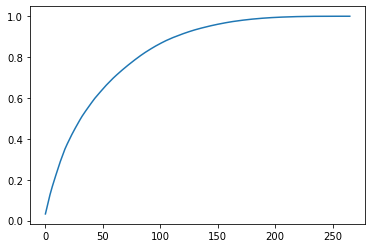

In [288]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X2_scaled, y2_scaled)
sorted_idx = np.argsort(fs.scores_)[::-1]
to_plot = fs.scores_[sorted_idx]
to_plot[np.isnan(to_plot)] = 0
to_plot /= to_plot.sum()
plt.plot(np.cumsum(to_plot))
stage_2_best_features_1 = df_X2.columns[sorted_idx[np.cumsum(to_plot)<0.9]].tolist()
print(f"Number of features: {len(stage_2_best_features_1)}")

Number of features: 125


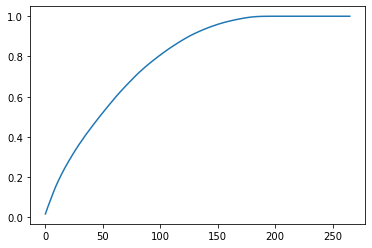

In [289]:
fs2 = SelectKBest(score_func=mutual_info_regression, k='all')
fs2.fit(X2_scaled, y2_scaled)

sorted_idx = np.argsort(fs2.scores_)[::-1]
to_plot = fs2.scores_[sorted_idx]
to_plot[np.isnan(to_plot)] = 0
to_plot /= to_plot.sum()
plt.plot(np.cumsum(to_plot))
stage_2_best_features_2 = df_X2.columns[sorted_idx[np.cumsum(to_plot)<0.9]].tolist()
print(f"Number of features: {len(stage_2_best_features_2)}")

In [292]:
stage_2_best_features = set(stage_2_best_features_1 + stage_2_best_features_2)
print(f"Number of features: {len(stage_2_best_features)}")
stage_2_best_features

Number of features: 168


{'capital_img_txt_perc',
 'full_img_txt_length',
 'img_height',
 'img_median',
 'img_median_s',
 'img_quantile_25_s',
 'img_std',
 'img_std_s',
 'img_w2h_ratio',
 'img_width',
 'm_v1_0',
 'm_v1_1',
 'm_v1_10',
 'm_v1_100',
 'm_v1_102',
 'm_v1_103',
 'm_v1_104',
 'm_v1_105',
 'm_v1_107',
 'm_v1_109',
 'm_v1_110',
 'm_v1_111',
 'm_v1_113',
 'm_v1_114',
 'm_v1_117',
 'm_v1_118',
 'm_v1_119',
 'm_v1_12',
 'm_v1_122',
 'm_v1_123',
 'm_v1_124',
 'm_v1_125',
 'm_v1_128',
 'm_v1_130',
 'm_v1_131',
 'm_v1_133',
 'm_v1_134',
 'm_v1_135',
 'm_v1_137',
 'm_v1_138',
 'm_v1_139',
 'm_v1_14',
 'm_v1_140',
 'm_v1_141',
 'm_v1_142',
 'm_v1_143',
 'm_v1_145',
 'm_v1_146',
 'm_v1_148',
 'm_v1_149',
 'm_v1_151',
 'm_v1_153',
 'm_v1_154',
 'm_v1_155',
 'm_v1_157',
 'm_v1_158',
 'm_v1_159',
 'm_v1_16',
 'm_v1_163',
 'm_v1_164',
 'm_v1_165',
 'm_v1_166',
 'm_v1_168',
 'm_v1_169',
 'm_v1_17',
 'm_v1_171',
 'm_v1_173',
 'm_v1_175',
 'm_v1_176',
 'm_v1_177',
 'm_v1_178',
 'm_v1_179',
 'm_v1_180',
 'm_v1_181',
 

In [297]:
stage_2_worst_features = df_X2.columns[~df_X2.columns.isin(stage_2_best_features)].tolist()
stage_2_worst_features

['m_v1_2',
 'm_v1_3',
 'm_v1_5',
 'm_v1_8',
 'm_v1_11',
 'm_v1_13',
 'm_v1_15',
 'm_v1_18',
 'm_v1_19',
 'm_v1_22',
 'm_v1_23',
 'm_v1_27',
 'm_v1_29',
 'm_v1_33',
 'm_v1_35',
 'm_v1_39',
 'm_v1_40',
 'm_v1_42',
 'm_v1_43',
 'm_v1_45',
 'm_v1_46',
 'm_v1_48',
 'm_v1_49',
 'm_v1_50',
 'm_v1_52',
 'm_v1_58',
 'm_v1_59',
 'm_v1_63',
 'm_v1_64',
 'm_v1_66',
 'm_v1_67',
 'm_v1_73',
 'm_v1_74',
 'm_v1_76',
 'm_v1_79',
 'm_v1_84',
 'm_v1_86',
 'm_v1_91',
 'm_v1_92',
 'm_v1_95',
 'm_v1_98',
 'm_v1_99',
 'm_v1_101',
 'm_v1_106',
 'm_v1_108',
 'm_v1_112',
 'm_v1_115',
 'm_v1_116',
 'm_v1_120',
 'm_v1_121',
 'm_v1_126',
 'm_v1_127',
 'm_v1_129',
 'm_v1_132',
 'm_v1_136',
 'm_v1_144',
 'm_v1_147',
 'm_v1_150',
 'm_v1_152',
 'm_v1_156',
 'm_v1_160',
 'm_v1_161',
 'm_v1_162',
 'm_v1_167',
 'm_v1_170',
 'm_v1_172',
 'm_v1_174',
 'm_v1_182',
 'm_v1_183',
 'm_v1_187',
 'm_v1_189',
 'm_v1_190',
 'm_v1_191',
 'm_v1_196',
 'm_v1_200',
 'm_v1_201',
 'm_v1_205',
 'm_v1_210',
 'm_v1_212',
 'm_v1_214',
 'm_v1

In [236]:
stage_2_scores_1 = fs.scores_
stage_2_scores_2 = fs2.scores_

## Rejecting the worst features from phases 1 and 2

In [301]:
worst_features = stage_1_worst_features + stage_2_worst_features
print(f"Number of features dropped: {len(worst_features)}")
df_f_train = df_f_train.drop(columns=worst_features)
df_f_test = df_f_test.drop(columns=worst_features)

Number of features dropped: 109


In [305]:
df_f_train.to_csv("etap_3_after/df_etap_3_after_features_train.csv")
df_f_test.to_csv("etap_3_after/df_etap_3_after_features_test.csv")
df_t_train.to_csv("etap_3_after/df_etap_3_after_target_train.csv")
df_t_test.to_csv("etap_3_after/df_etap_3_after_target_test.csv")

# Summary of evaluations of variance, mutual information and f_regression - UNUSED

In [152]:
def normalize_scores(scores):
    scores = scores.copy()
    scores[np.isnan(scores)] = 0
    return scores / scores.sum()

svar = normalize_scores(variance_scores)
s11 = normalize_scores(stage_1_scores_1)
s12 = normalize_scores(stage_1_scores_2)
s21 = normalize_scores(stage_2_scores_1)
s22 = normalize_scores(stage_2_scores_2)

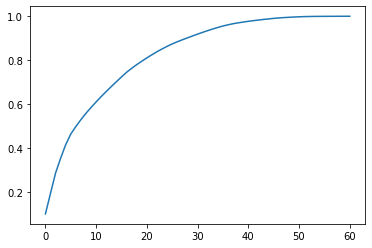

In [161]:
accumulated_scores = svar[df_f_train.columns.isin(df_X1.columns)]
accumulated_scores /= accumulated_scores.sum()
accumulated_scores = accumulated_scores + s11 + s12
accumulated_scores /= accumulated_scores.sum()
plt.plot(np.cumsum(np.sort(accumulated_scores)[::-1]))

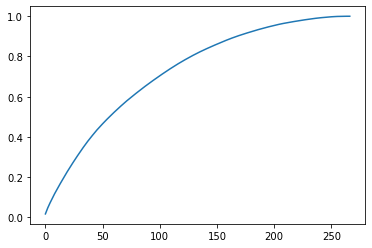

In [162]:
accumulated_scores = svar[df_f_train.columns.isin(df_X2.columns)]
accumulated_scores /= accumulated_scores.sum()
accumulated_scores = accumulated_scores + s21 + s22
accumulated_scores /= accumulated_scores.sum()
plt.plot(np.cumsum(np.sort(accumulated_scores)[::-1]))

# Selection by recursive feature elimination - UNUSED

In [15]:
%%time
xg_reg = xgb.XGBRegressor(max_depth = 5)
estimator = xg_reg  # SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=1, step=1, verbose=1)
selector = selector.fit(df_X, df_y.iloc[:, 0])
selector.support_

Fitting estimator with 346 features.
Fitting estimator with 345 features.
Fitting estimator with 344 features.
Fitting estimator with 343 features.
Fitting estimator with 342 features.
Fitting estimator with 341 features.
Fitting estimator with 340 features.
Fitting estimator with 339 features.
Fitting estimator with 338 features.
Fitting estimator with 337 features.
Fitting estimator with 336 features.
Fitting estimator with 335 features.
Fitting estimator with 334 features.
Fitting estimator with 333 features.
Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
F

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,

In [16]:
selector.ranking_

array([ 49, 119, 291, 112, 290, 257, 288, 125, 301,  22,   9,  28,  73,
       299, 233, 305, 289, 292, 297, 302, 237, 228, 295, 314, 181, 317,
       316, 320, 262, 313, 296, 279, 161, 330, 332, 315, 324, 328, 253,
       306, 307, 304, 207,  45, 189, 308,  60,  17, 345,  90,  16, 342,
       123,   3,  14, 184, 173,  27, 339, 323, 162, 246, 146, 285, 278,
       318, 303, 248, 321, 326, 100, 241,  69, 216, 319,  31,  38, 107,
       143,  55,  97,  80,  43, 338, 329, 150, 163, 153,  35, 254, 204,
       167, 238,  59, 309,   4, 220,  82, 344, 197,  15, 115, 106, 337,
         8, 263, 336, 128, 140, 116, 334, 155, 118, 239, 148,  62, 159,
        98, 260, 134, 224,   1, 185, 258, 270, 271,  84, 205, 340, 141,
       200, 234,  89, 206, 164, 160, 124, 215, 221,  75,  95,  33, 275,
       158,  70, 277,   6,  68, 298, 126, 175, 211, 219,  54,  87,  47,
        10, 226, 282, 102,  18,  30, 144, 170, 322, 122, 186, 343,  24,
       286, 171, 268, 188,  81, 110, 138, 335, 127, 331,  57, 11

In [25]:
df_X.columns[selector.ranking_.argsort()][:100]

Index(['m_v1_36', 'm_v1_240', 'img_width', 'm_v1_10', 'm_v1_154', 'm_v1_61',
       'm_v1_166', 'm_v1_19', 'VS_neu', 'm_v1_71', 'm_v1_180', 'm_v1_122',
       'm_v1_123', 'img_w2h_ratio', 'm_v1_15', 'days_from_start',
       'minutes_from_midnight', 'm_v1_75', 'm_v1_252', 'm_v1_188', 'm_v1_142',
       'VS_pos', 'm_v1_151', 'm_v1_83', 'm_v1_134', 'm_v1_224', 'img_std',
       'VS_neg', 'm_v1_128', 'm_v1_76', 'img_median_s', 'm_v1_232', 'm_v1_56',
       'm_v1_117', 'm_v1_3', 'capital_img_txt_perc', 'm_v1_112', 'img_mean_s',
       'm_v1_175', 'm_v1_179', 'm_v1_148', 'm_v1_223', 'img_std_v', 'm_v1_213',
       'lda_topic_prob', 'm_v1_201', 'm_v1_70', 'm_v1_138', 'full_text_length',
       'm_v1_170', 'm_v1_209', 'm_v1_130', 'm_v1_227', 'm_v1_68',
       'img_quantile_75_s', 'm_v1_183', 'm_v1_94', 'm_v1_113', 'm_v1_8',
       'weekday', 'm_v1_249', 'm_v1_30', 'm_v1_230', 'm_v1_204', 'm_v1_135',
       'm_v1_219', 'm_v1_97', 'm_v1_62', 'img_std_r', 'm_v1_59', 'm_v1_199',
       'm_v1_195'

**Problem - it is difficult to train the regressor**

In [4]:
df_X_after = pd.read_csv('etap_3_after/df_etap_3_after_features_train.csv', index_col=0)
df_y_after = pd.read_csv('etap_3_after/df_etap_3_after_target_train.csv', index_col=0)

df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_X_after, df_y_after, random_state=0)

In [7]:
xg_reg = xgb.XGBRegressor(max_depth = 5)
xg_reg.fit(df_X_train, df_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

/home/ciasterix/anaconda3/envs/nlp/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/ciasterix/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


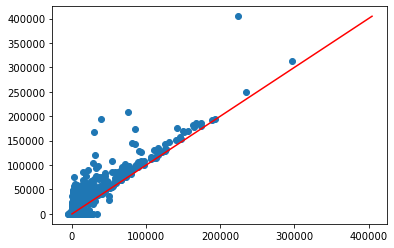

In [8]:
preds = xg_reg.predict(df_X_train)
plt.scatter(preds, df_y_train)
plt.plot([0, df_y_train.max()],[0, df_y_train.max()], color='red')
plt.show()

/home/ciasterix/anaconda3/envs/nlp/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/ciasterix/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


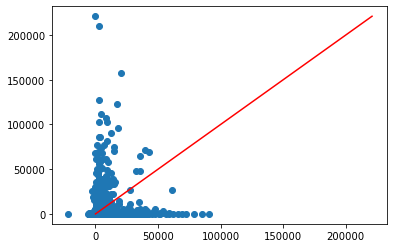

In [9]:
preds = xg_reg.predict(df_X_val)
plt.scatter(preds, df_y_val)
plt.plot([0, df_y_val.max()],[0, df_y_val.max()], color='red')
plt.show()